#TC2004B - Análisis de Ciencia de Datos
## Agrupar comentarios y clasificación de productos
### Steffany Lara
####A00838589

#TC2004B - Ciencia de Datos
## Reto Clubers

### Procedimiento
1. Generar las categorias de la comida: basandome en la base de datos menus.csv. Por medio de ML no supervisado con jerarquía encontrar las 5 categorías exitentes (por decisión) con base al word2vec de los vectores. Luego asignar una categoría a cada uno de los alimentos del menu.
2. Asignar las 5 categorías a cada restaurante, de manera que es una base de datos con un vector que dice que porcentaje de cada categoría poseen.
2.1 Como no tengo esas encuestas haré una suma por ahora de los restaurantes que ha visitado el usuario :) para sacar los gustos, luego los normalizo para que de 1.
3. Hacer encuestas a las personas para que digan que les gusta, que elijan las 5 categorías que mas les llama la atención y en que medida. Eso estará guardado por cada usuario como fila de una matriz tipo [0.2 0.4 ... ]total sobre las 5 categorias
4. Con base a la base de datos ordenes-consumo.csv tomar tambien para entrenar al modelo. Tipo saber que suele consumir la gente segun al id del restaurante, que categorias, para entrenar el modelo, la otra es hacer encuestas pero no da el tiempo.
5. Forzar la encuesta para el update de la actualización.
6. Entrenar el modelo de inteligencia artificial que toma la base de datos de ordenes-consumo para asignar un gusto a las personas. Matematicamente hablando, se calcula por persona cuanto es su gasto promedio por ticket, y cada que se le recomeinda se le va a recomendar algo 0.1 mas caro a su ticket promedio para aumentar con el tiempo. Tambien cada que vaya a un restaurante le voy a sumar ponete:

va al r1 donde las categorias valen [0.1, 0.4, 0.4,0.2] al valor de la persona le sumaría ese vector y a lo que pidio asumamos pidio 3 cosas de categoria 1 entonces se va a sumar solo a esa categoría 0.5 digamos y luego vamos haciendo el match. Entonces recomienda con base a lo que se ajuste mas a su gusto, pero tambien del restaurante que este cercad e sus coordenadas acutales yo diria que a un radio de 1km. NO se como variarle para que no siempre le salga lo mismo tbh.

7. Quería implementar una ruleta, donde con base a sus decisiones no se en eleccion una tipo mini encuesta le haga perfect match.

8. Tambien queria recomendar el platillo estrella de cada restaurante con base a la frecuencia que se ordena en cada lugar. De manera que recomiende eso.

9. Pues ya eso sería todo, para recomenda, lo único es que se debe contemplar el horario de atención del restaurante.  NO se si teiens otra propuesta y si sabes como podira abordar este problema.

In [49]:
'''
Actividad 1 – Agrupación de Comentarios de Clientes
Word2Vec + KMeans + PCA
'''
# ─────────────────────────── imports ───────────────────────────
import pandas as pd, numpy as np, re, string, collections, itertools, seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, confusion_matrix,
    classification_report, f1_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import json, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA              # ← usamos PCA para visualización
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
print('Importados')

Importados


## Limpieza del Dataset

✔ Productos válidos: 30486
✔ k elegido: 9

Categorías únicas después del etiquetado:
category
Comida Rápida    7892
Italiana         4528
Saludable        4220
Categoría_8      3646
Categoría_2      2763
Desayunos        2644
Asiática         1660
Bebidas          1620
Postres          1513
Name: count, dtype: int64

Categorías en conjunto de prueba:
category
Comida Rápida    1578
Italiana          906
Saludable         844
Categoría_8       729
Categoría_2       553
Desayunos         529
Asiática          332
Bebidas           324
Postres           303
Name: count, dtype: int64

=== Métricas KNN ===
               precision    recall  f1-score   support

     Asiática       0.95      0.91      0.93       332
      Bebidas       0.95      0.93      0.94       324
  Categoría_2       0.94      0.95      0.94       553
  Categoría_8       0.89      0.86      0.88       729
Comida Rápida       0.94      0.93      0.93      1578
    Desayunos       0.90      0.93      0.91       529
     I

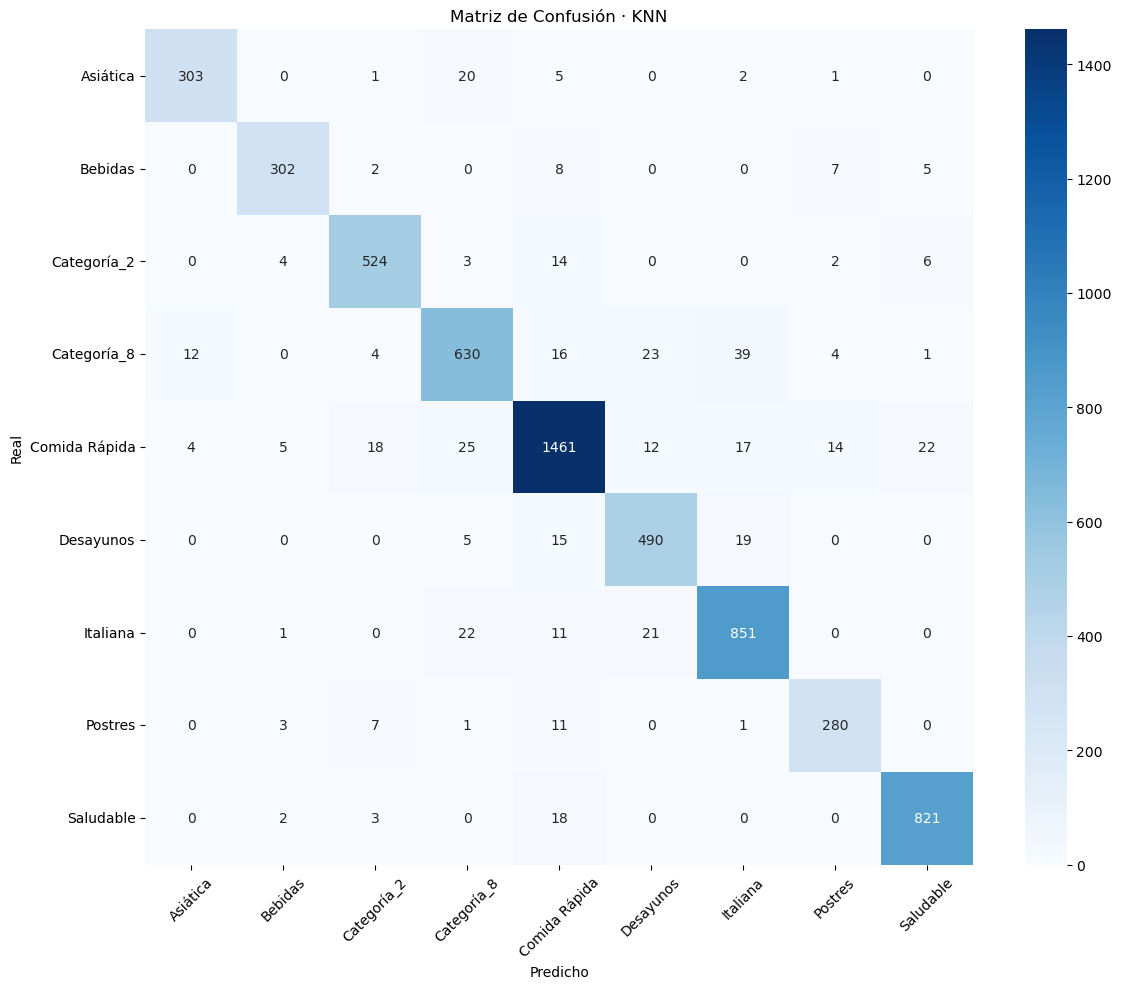

In [50]:

# ─────────────── helpers de preprocesamiento ───────────────
STOP = {  # Lista personalizada de stopwords en español
    'de','la','que','el','en','y','a','los','del','se','las','por','un','para',
    'con','no','una','su','al','lo','como','más','pero','sus','le','ya','o',
    'este','sí','porque','esta','entre','cuando','muy','sin','sobre','también',
    'me','hasta','hay','donde','quien','desde','todo','nos','com'
}
PUNCT = str.maketrans('', '', string.punctuation)  # Para eliminar puntuación

def clean(text:str)->list[str]:
    text = re.sub(r'\d+','', (text or '').lower().translate(PUNCT))  # Limpia números y puntuación
    return [t for t in text.split() if t not in STOP and len(t)>2]  # Filtra palabras útiles

# ─────────────── 1. cargar datos y tokenizar ───────────────
df = pd.read_csv('menus.csv', encoding='utf-8')  # Carga el CSV

df['Name']        = df['Name'].fillna('')  # Rellena vacíos en columna Name
df['Description'] = df['Description'].fillna('')  # Rellena vacíos en Description
df['tokens']      = (df['Name']+' '+df['Description']).apply(clean)  # Aplica limpieza al texto

df = df[df['tokens'].str.len()>0].reset_index(drop=True)  # Solo deja filas con al menos un token
print(f'✔ Productos válidos: {len(df)}')  # Muestra cuántos productos quedaron

# ─────────────── 2. Word2Vec & obtención de vectores ───────────────
w2v = Word2Vec(sentences=df['tokens'],  # Entrena modelo Word2Vec con los tokens
               vector_size=100, window=5,
               min_count=2, workers=4, epochs=40)

def to_vec(tok):  # Convierte lista de palabras a vector promedio
    vecs=[w2v.wv[w] for w in tok if w in w2v.wv]  # Solo palabras conocidas por el modelo
    return np.mean(vecs,0) if vecs else np.zeros(w2v.vector_size)  # Vector promedio o vector cero

X = np.vstack(df['tokens'].apply(to_vec).values)  # Aplica to_vec a todos los productos

# ─────────────── 3. k óptimo (codo + silhouette)  ⇒  k ≥ 5 ───────────────
def best_k_min4(X, k_max=10, k_min=9):
    inert, sil = [], []
    for k in range(2, k_max+1):  # Prueba valores de k desde 2 hasta 10
        km = KMeans(k, random_state=42, n_init=10).fit(X)
        inert.append(km.inertia_)  # Guarda inercia (para codo)
        sil.append(silhouette_score(X, km.labels_))  # Guarda silhouette
    k_star = np.argmax(sil) + 2  # El mejor k por silhouette (ajustado por índice)
    return max(k_star, k_min)  # Forzamos mínimo de 4

k = best_k_min4(X, k_max=10, k_min=9)  # Elegimos el k final
print(f'✔ k elegido: {k}')

# ─────────────── 4. K-Means + silhouette ───────────────
km = KMeans(k, random_state=42, n_init=10).fit(X)  # Aplicamos KMeans final

df['cluster'] = km.labels_  # Guardamos a qué cluster pertenece cada producto
sil_global = silhouette_score(X, df['cluster'])  # Calculamos score silhouette total

# ─────────────── 5. etiquetado automático de categorías (versión mejorada) ───────────────
def top_words(idxs, n=10):
    return [w for w, _ in collections.Counter(
        itertools.chain.from_iterable(df.loc[idxs, 'tokens'])
    ).most_common(n)]

# Usamos un mapeo más preciso y verificamos categorías únicas
name_map = {}
unique_categories = set()

for c in range(k):
    vocab = ' '.join(top_words(df.index[df.cluster == c], 20))
    
    # Asegurar que cada cluster reciba una categoría única
    if re.search(r'\b(huevo|desayuno|chilaquiles|pancake|waffle|omelet|mollete|hotcake|bisquet)\b', vocab) and 'Desayunos' not in unique_categories:
        name_map[c] = 'Desayunos'
        unique_categories.add('Desayunos')
    elif re.search(r'\b(pasta|lasagna|pizza|fettuccine|bolognesa|carbonara|crema|sopa)\b', vocab) and 'Italiana' not in unique_categories:
        name_map[c] = 'Italiana'
        unique_categories.add('Italiana')
    elif re.search(r'\b(sushi|ramen|roll|wok|teriyaki|pescado)\b', vocab) and 'Asiática' not in unique_categories:
        name_map[c] = 'Asiática'
        unique_categories.add('Asiática')
    elif re.search(r'\b(curry|masala|naan|kebab|shawarma|falafel|hummus)\b', vocab) and 'India / Oriente' not in unique_categories:
        name_map[c] = 'India / Oriente'
        unique_categories.add('India / Oriente')
    elif re.search(r'\b(taco|enchil|quesa|chila|mexican|sopes|tlayuda|huarache|gordita|pozol|tlacoyo|cochinita|barbacoa|arrachera|carne|res|cerdo)\b', vocab) and 'Mexicana' not in unique_categories:
        name_map[c] = 'Mexicana'
        unique_categories.add('Mexicana')
    elif re.search(r'\b(ensalad|salad|light|healthy|fit|keto|vegetar|pollo)\b', vocab) and 'Saludable' not in unique_categories:
        name_map[c] = 'Saludable'
        unique_categories.add('Saludable')
    elif re.search(r'\b(hamburguesa|hambur|burger|hotdog|nugget|pollofrito|boneless|alitas|fastfood|papasfritas|combo|filete)\b', vocab) and 'Comida Rápida' not in unique_categories:
        name_map[c] = 'Comida Rápida'
        unique_categories.add('Comida Rápida')
    elif re.search(r'\b(café|te|latte|jug|limonada|soda|agua|refresco|matcha|frapp|bebid|cola|coca)\b', vocab) and 'Bebidas' not in unique_categories:
        name_map[c] = 'Bebidas'
        unique_categories.add('Bebidas')
    elif re.search(r'\b(brownie|flan|pastel|postr|chocolate|cheesecake|helado|gelatina|donut|galleta|pay|bizcocho|chocolate|vainilla)\b', vocab) and 'Postres' not in unique_categories:
        name_map[c] = 'Postres'
        unique_categories.add('Postres')
    else:
        name_map[c] = f'Categoría_{c}'  # Evitar "Otros" genérico

df['category'] = df['cluster'].map(name_map)

# Verificar que tenemos 9 categorías únicas
print("\nCategorías únicas después del etiquetado:")
print(df['category'].value_counts())

# ─────────────── 7. KNN entrenamiento y métricas (versión mejorada) ───────────────
# Forzar la inclusión de todas las categorías
Xtr, Xts, ytr, yts = train_test_split(
    X, df['category'],
    test_size=0.2,
    random_state=42,
    stratify=df['category']
)

# Verificar categorías en yts
print("\nCategorías en conjunto de prueba:")
print(yts.value_counts())

# Entrenar KNN solo si tenemos múltiples clases
if len(np.unique(ytr)) > 1:
    knn = KNeighborsClassifier(9).fit(Xtr, ytr)
    prediccion_categoria_alimento = knn.predict(Xts)
    
    print('\n=== Métricas KNN ===')
    print(classification_report(yts, prediccion_categoria_alimento, zero_division=0))
    print('Macro-F1:', f1_score(yts, prediccion_categoria_alimento, average='macro').round(3))
    
    # Matriz de confusión con todas las categorías
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        confusion_matrix(yts, prediccion_categoria_alimento, labels=np.unique(ytr)),
        annot=True, fmt='d', cmap='Blues',
        xticklabels=np.unique(ytr), 
        yticklabels=np.unique(ytr)
    )
    plt.title('Matriz de Confusión · KNN')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_knn.png', dpi=300)
    plt.show()
else:
    print("¡Advertencia! Solo se encontró 1 categoría en los datos")

Generando visualización PCA 3D...


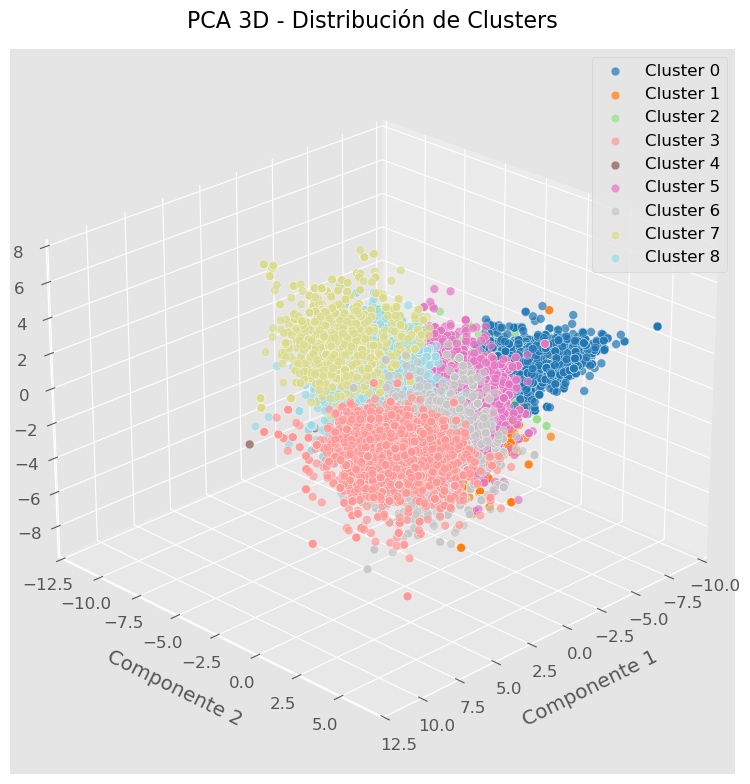


Generando visualización t-SNE 3D...


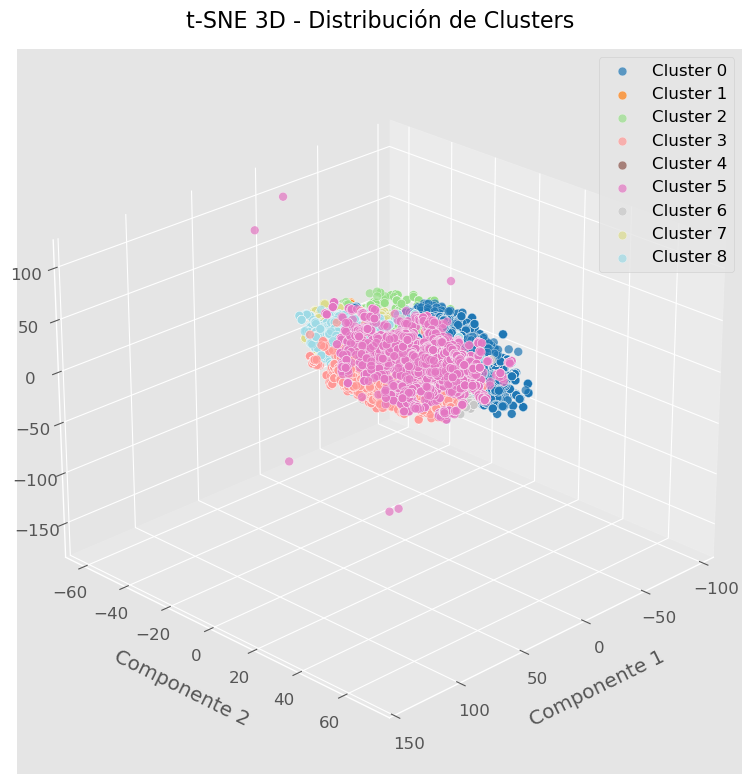


✔ Visualizaciones guardadas como 'pca_3d_clusters.png' y 'tsne_3d_clusters.png'


In [52]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Configuración de estilo para las gráficas
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

# Reducción de dimensionalidad
def reduce_and_plot(X, labels, method='pca', perplexity=30):
    if method == 'pca':
        reducer = PCA(n_components=3)
        title = 'PCA 3D - Distribución de Clusters'
    else:  # t-SNE
        reducer = TSNE(n_components=3, perplexity=perplexity, 
                      max_iter=1000, random_state=42, n_jobs=-1)
        title = 't-SNE 3D - Distribución de Clusters'
    
    # Reducción de dimensionalidad
    X_reduced = reducer.fit_transform(X)
    
    # Creación de la figura 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Mapeo de colores por cluster
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    color_map = dict(zip(unique_labels, colors))
    
    # Scatter plot 3D
    for cluster in unique_labels:
        idx = labels == cluster
        ax.scatter(
            X_reduced[idx, 0], X_reduced[idx, 1], X_reduced[idx, 2],
            color=color_map[cluster],
            label=f'Cluster {cluster}',
            alpha=0.7,
            s=40,  # Tamaño de puntos
            edgecolor='w',
            linewidth=0.3
        )
    
    # Configuración de la gráfica
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_xlabel('Componente 1', labelpad=10)
    ax.set_ylabel('Componente 2', labelpad=10)
    ax.set_zlabel('Componente 3', labelpad=10)
    
    # Leyenda y ángulo de vista
    ax.legend(loc='best', bbox_to_anchor=(1, 1), ncol=2 if len(unique_labels) > 10 else 1)
    ax.view_init(elev=25, azim=45)  # Ángulo de visualización óptimo
    
    # Guardar y mostrar
    plt.tight_layout()
    plt.savefig(f'{method}_3d_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return X_reduced

# ─────────────── Visualización de Clusters ───────────────
print("Generando visualización PCA 3D...")
X_pca3 = reduce_and_plot(X, df['cluster'], method='pca')

print("\nGenerando visualización t-SNE 3D...")
X_tsne3 = reduce_and_plot(X, df['cluster'], method='tsne', perplexity=30)

print("\n✔ Visualizaciones guardadas como 'pca_3d_clusters.png' y 'tsne_3d_clusters.png'")

In [77]:
nombre = "pastel de chocolate"
descripcion = "bizcocho de chocolate con frutas"
vec = to_vec(clean(f'{nombre} {descripcion}'))
probs = knn.predict_proba([vec])[0]

for cat, prob in zip(knn.classes_, probs):
    print(f'{cat} → {prob}')


Asiática → 0.0
Bebidas → 0.0
Categoría_2 → 0.0
Categoría_8 → 0.0
Comida Rápida → 0.0
Desayunos → 0.0
Italiana → 0.0
Postres → 1.0
Saludable → 0.0


In [72]:
# ─────────────── 8. Asignación de probabilidades por categoría ───────────────
# Obtener la lista de categorías únicas ordenadas
df_menus_clubers = pd.get_dummies(df, columns=['category'])
df_menus_clubers.info()
categories = sorted(df['category'].unique())

# Crear columnas de probabilidad para cada categoría
for cat in categories:
    col_name = f'category_{cat.replace(" ", "_").replace("/", "_")}'
    df[col_name] = 0.0  # Inicializar todas con 0.0

# Función para obtener probabilidades y asignarlas a las columnas
def get_category_probs(row):
    try:
        # Obtener el vector del producto
        text = f"{row['Name']} {row['Description']}"
        vec = to_vec(clean(text))
        
        # Obtener probabilidades del modelo
        probs = knn.predict_proba([vec])[0]
        
        # Asignar cada probabilidad a su columna correspondiente
        for cat, prob in zip(knn.classes_, probs):
            col_name = f'category_{cat.replace(" ", "_").replace("/", "_")}'
            row[col_name] = round(prob, 4)  # Redondear a 4 decimales
            
    except Exception as e:
        print(f"Error procesando fila {row.name}: {str(e)}")
    
    return row

# Aplicar la función a cada fila del DataFrame
df = df.apply(get_category_probs, axis=1)

# Mostrar las nuevas columnas creadas
print("\nColumnas de probabilidad creadas:")
print(df.filter(like='category_').head())

# Guardar el DataFrame completo con las probabilidades
print("✔ DataFrame guardado con probabilidades por categoría")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30486 entries, 0 to 30485
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      30486 non-null  int64  
 1   StatusId                30486 non-null  int64  
 2   Created                 30486 non-null  object 
 3   CreatedById             30486 non-null  int64  
 4   Modified                20277 non-null  object 
 5   ModifiedById            20277 non-null  float64
 6   EstablishmentId         30486 non-null  int64  
 7   Name                    30486 non-null  object 
 8   Description             30486 non-null  object 
 9   HomePrice               30486 non-null  int64  
 10  OnSitePrice             30486 non-null  float64
 11  AvailableHome           30486 non-null  int64  
 12  AvailableOnSite         30486 non-null  int64  
 13  PreparationTime         30486 non-null  int64  
 14  Available               30486 non-null

,Id,StatusId,Created,CreatedById,Modified,ModifiedById,EstablishmentId,Name,Description,HomePrice,...,category,category_Asiática,category_Bebidas,category_Categoría_2,category_Categoría_8,category_Comida_Rápida,category_Desayunos,category_Italiana,category_Postres,category_Saludable
0,1,1,43:54.1,6,23:14.8,28.0,1,Tamaquiles,Deliciosos tamales dorados y bañados en salsa ...,0,...,Desayunos,0.0,0.0,0.0,0.2222,0.0000,0.7778,0.0,0.0000,0.0
1,2,1,06:03.4,6,20:07.6,6.0,1,Huevos al Gusto,"A la mexicana, revuelto, jamón, estrellado, co...",0,...,Desayunos,0.0,0.0,0.0,0.0000,0.0000,1.0000,0.0,0.0000,0.0
2,3,1,07:10.8,1,17:42.8,1.0,3,Bisquets con mermelada,2 deliciosas piezas de bisquets sabor a mante...,0,...,Comida Rápida,0.0,0.0,0.0,0.0000,1.0000,0.0000,0.0,0.0000,0.0
3,4,1,11:52.2,1,25:26.4,1.0,3,Hot Cakes,3 piezas de esponjosos hot cakes con fresa nat...,0,...,Postres,0.0,0.0,0.0,0.0000,0.7778,0.0000,0.0,0.2222,0.0
4,5,1,14:16.4,6,24:43.7,6.0,1,Molletes,"Telera embarrada con fijoles con chorizo, mix ...",0,...,Desayunos,0.0,0.0,0.0,0.0000,0.0000,1.0000,0.0,0.0000,0.0



=== Distribución de Categorías ===
Total de productos: 30486

Porcentaje por categoría:
- Comida Rápida: 25.89%
- Italiana: 14.85%
- Saludable: 13.84%
- Categoría_8: 11.96%
- Categoría_2: 9.06%
- Desayunos: 8.67%
- Asiática: 5.45%
- Bebidas: 5.31%
- Postres: 4.96%


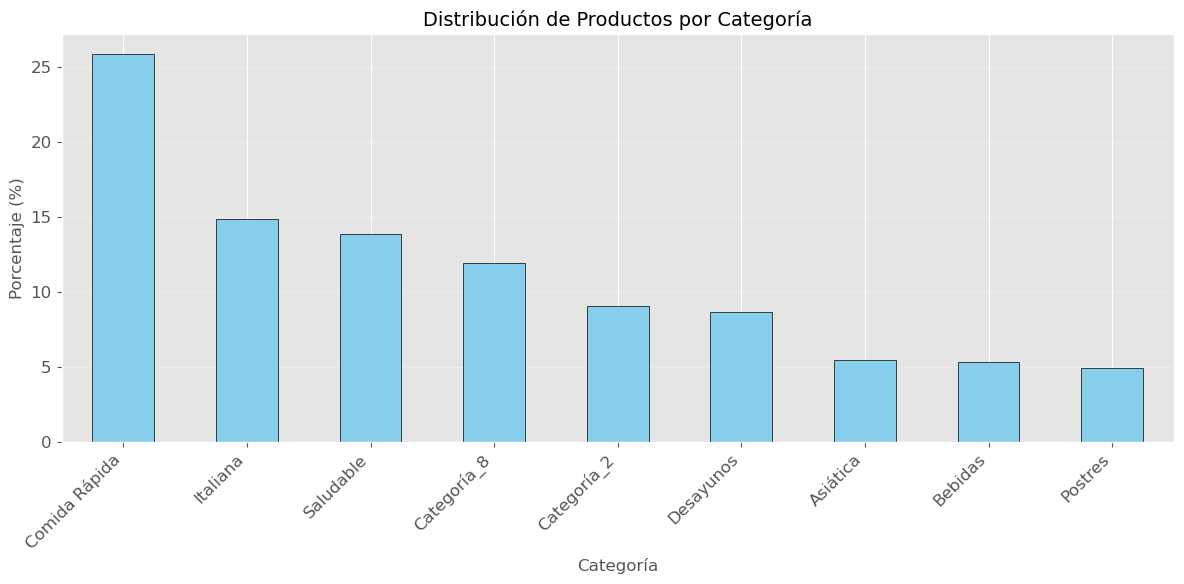

In [79]:

df['category'] = df['cluster'].map(name_map)  # Asigna categoría final a cada producto

# ─────────────── 5.1 Análisis de distribución por categoría ───────────────
# Calcular porcentaje de productos por categoría
categoria_counts = df['category'].value_counts()
porcentajes = (categoria_counts / len(df)) * 100

print("\n=== Distribución de Categorías ===")
print(f"Total de productos: {len(df)}")
print("\nPorcentaje por categoría:")
for categoria, porcentaje in porcentajes.items():
    print(f"- {categoria}: {porcentaje:.2f}%")

# Gráfico de distribución
plt.figure(figsize=(12, 6))
porcentajes.sort_values(ascending=False).plot(
    kind='bar', color='skyblue', edgecolor='black'
)
plt.title('Distribución de Productos por Categoría', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('distribucion_categorias.png', dpi=300)
plt.show()


In [88]:
#¿Quién es categoría 8 y 2?

df_filtrado = df[df['category_Categoría_2'] == 1]
df_filtrado.head()

df_filtrado = df[(df['category_Bebidas'] < 1) & (df['category_Categoría_2'] > 0)]
df_filtrado.head()


,Id,StatusId,Created,CreatedById,Modified,ModifiedById,EstablishmentId,Name,Description,HomePrice,...,category,category_Asiática,category_Bebidas,category_Categoría_2,category_Categoría_8,category_Comida_Rápida,category_Desayunos,category_Italiana,category_Postres,category_Saludable
5,6,1,15:26.1,1,39:59.3,6.0,3,Ensalada de frutas,"Exquisita combinación de papaya, plátano, meló...",0,...,Comida Rápida,0.0,0.0,0.4444,0.0,0.2222,0.0,0.0,0.3333,0.0
58,60,1,06:07.7,6,46:23.8,6.0,1,Agua Natural,Agua Natural,0,...,Categoría_2,0.0,0.0,1.0000,0.0,0.0000,0.0,0.0,0.0000,0.0
59,61,1,06:34.9,6,46:32.7,6.0,1,Agua Jamaica,Agua Jamaica,0,...,Categoría_2,0.0,0.0,1.0000,0.0,0.0000,0.0,0.0,0.0000,0.0
61,63,2,07:07.3,6,12:16.8,1256.0,1,Agua Horchata,Agua Horchata,0,...,Categoría_2,0.0,0.0,1.0000,0.0,0.0000,0.0,0.0,0.0000,0.0
62,64,1,07:39.9,6,46:45.9,6.0,1,Agua Tamarindo,Agua Tamarindo,0,...,Categoría_2,0.0,0.0,1.0000,0.0,0.0000,0.0,0.0,0.0000,0.0


In [129]:
print(df)

          Id  StatusId  Created  CreatedById Modified  ModifiedById  \
0          1         1  43:54.1            6  23:14.8          28.0   
1          2         1  06:03.4            6  20:07.6           6.0   
2          3         1  07:10.8            1  17:42.8           1.0   
3          4         1  11:52.2            1  25:26.4           1.0   
4          5         1  14:16.4            6  24:43.7           6.0   
...      ...       ...      ...          ...      ...           ...   
30481  31481         1  39:04.1        45974      NaN           NaN   
30482  31482         1  09:19.4        45974  10:34.1       45974.0   
30483  31483         1  30:26.9        45974  04:30.0       45974.0   
30484  31484         1  33:19.7        45974  07:01.1       45974.0   
30485  31485         1  35:49.7        45974  35:59.9       45974.0   

       EstablishmentId                                               Name  \
0                    1                                         Tamaqui

Df con menús para identificar el porcentaje de categoría por alimento.

In [128]:
# EstablishmentId Si se importan los datos con base al modelo entrenado 

# ─────────────── 6. Generar matriz restaurante vs categorías ───────────────
# Calcular pesos normalizados por restaurante
restaurant_cats = (
    df.groupby(['EstablishmentId', 'category'])
    .size()
    .reset_index(name='count')
)

# Normalizar los conteos por restaurante
restaurant_totals = restaurant_cats.groupby('EstablishmentId')['count'].transform('sum')
restaurant_cats['weight'] = restaurant_cats['count'] / restaurant_totals

# Pivotar para obtener la matriz restaurante vs categorías
df_pivot = restaurant_cats.pivot_table(
    index='EstablishmentId',
    columns='category',
    values='weight',
    fill_value=0
).reset_index()

print("Matriz restaurante vs categorías:")
print(df_pivot.head())
print(1234567890)
'''
# ─────────────── 7. Construir tabla de significados ───────────────
categorias_unicas = sorted(df['category'].unique())
tabla_significados = pd.DataFrame({
    'category': categorias_unicas,
    'significado': [
        "Platos tradicionales mexicanos como tacos, enchiladas y guisados",
        "Opciones con ingredientes frescos y preparaciones ligeras",
        "Hamburguesas, papas fritas y comida rápida",
        "Cafés, tés, jugos y refrescos",
        "Pasteles, flanes y dulces tradicionales",
        "Platos matutinos como huevos y pan dulce",
        "Pastas, pizzas y platillos con salsas italianas",
        "Sushi, fideos orientales y woks",
        "Currys, panes planos y sabores exóticos"
    ]  # Personaliza estas descripciones
})

print("\nTabla de significados:")
print(tabla_significados)
'''
df_categorias_restaurantes_clubers=df_pivot.copy()

Matriz restaurante vs categorías:
category  EstablishmentId  Asiática   Bebidas  Categoría_2  Categoría_8  \
0                       1       0.0  0.054795     0.095890     0.027397   
1                       2       0.0  0.281250     0.062500     0.031250   
2                       3       0.0  0.020000     0.130000     0.140000   
3                       4       0.0  0.000000     0.058824     0.058824   
4                       5       0.0  0.000000     0.015152     0.030303   

category  Comida Rápida  Desayunos  Italiana   Postres  Saludable  
0              0.315068   0.082192  0.287671  0.041096   0.095890  
1              0.218750   0.062500  0.104167  0.208333   0.031250  
2              0.180000   0.310000  0.120000  0.090000   0.010000  
3              0.372549   0.372549  0.078431  0.000000   0.058824  
4              0.181818   0.030303  0.712121  0.015152   0.015152  
1234567890


In [150]:
!pip install ace_tools

In [131]:
import pandas as pd

# —————— 1. Carga CSV de socios ——————
df_socios = pd.read_csv(
    'socios consumidores.csv',
    encoding='latin1',
    dtype=str,
    dayfirst=True
)
df_socios = df_socios.rename(columns={'idConsumidor': 'NumeroSocioConsumidor'})

# —————— 2. Mapear Género a códigos numéricos ——————
# Valores posibles: ['Otro', 'Hombre', 'Mujer', 'Prefiero no decirlo', nan]
# Queremos: Mujer → 0, Hombre → 1, Prefiero no decirlo/Otro/nan → 3
map_genero = {
    'Mujer': 0,
    'Hombre': 1,
    'Prefiero no decirlo': 3,
    'Otro': 3
}

df_socios['Genero'] = df_socios['Genero'].map(map_genero).fillna(3).astype(int)

# —————— 3. Construir df_final con categorías inicializadas en 0 ——————
# Asume que 'nuevos_nombres' ya existe y lista códigos c1…cN
columnas_cats = list(df.columns[20:])


df_final = pd.DataFrame({
    'NumeroSocioConsumidor': df_socios['NumeroSocioConsumidor'],
    'Genero': df_socios['Genero']
})
df_final['MontoPromedio'] = 0.0
for c in columnas_cats:
    df_final[c] = 0.0
df_final.drop(columns={'cluster'})
df_final.rename(
    columns=lambda x: x.replace('category_', '') if x.startswith('category_') else x,
    inplace=True
)

# —————— 4. Mostrar resultado ——————
print(df_final.head())
print("Géneros únicos en df_final:", df_final['Genero'].unique())


  NumeroSocioConsumidor  Genero  MontoPromedio  cluster  category  Asiática  \
0                    24       3            0.0      0.0       0.0       0.0   
1                    25       3            0.0      0.0       0.0       0.0   
2                    27       3            0.0      0.0       0.0       0.0   
3                    29       3            0.0      0.0       0.0       0.0   
4                    30       3            0.0      0.0       0.0       0.0   

   Bebidas  Categoría_2  Categoría_8  Comida_Rápida  Desayunos  Italiana  \
0      0.0          0.0          0.0            0.0        0.0       0.0   
1      0.0          0.0          0.0            0.0        0.0       0.0   
2      0.0          0.0          0.0            0.0        0.0       0.0   
3      0.0          0.0          0.0            0.0        0.0       0.0   
4      0.0          0.0          0.0            0.0        0.0       0.0   

   Postres  Saludable  
0      0.0        0.0  
1      0.0        0.

In [165]:
import re
import pandas as pd

# —————— 0. Tu df_categorias_restaurantes_clubers ya cargado ——————
# Ejemplo de carga:
# df_categorias_restaurantes_clubers = pd.read_csv('pivot.csv', encoding='latin1')
# Debe tener 'EstablishmentId' + columnas de categoría

cat_cols = [c for c in df_categorias_restaurantes_clubers.columns if c != 'EstablishmentId']

# —————— 1. Encuestas (opcional) ——————
'''
df_enc = pd.read_csv('encuestas_consumidor.csv', encoding='latin1')
col = next((c for c in df_enc.columns if re.search(r'consumidor', c, re.IGNORECASE)), None)
if not col:
    raise KeyError("No se encontró columna de consumidor en encuestas_consumidor.csv")
df_enc = df_enc.rename(columns={col: 'NumeroSocioConsumidor'})

enc_cols = [c for c in cat_cols if c in df_enc.columns]
enc_peso4 = df_enc[['NumeroSocioConsumidor'] + enc_cols].copy()
enc_peso4[enc_cols] *= 4

mask_completa = (enc_peso4[enc_cols] > 0).all(axis=1)
enc_peso4 = enc_peso4[mask_completa].reset_index(drop=True)
'''

# —————— 2. Órdenes de consumo ——————
df_ord = pd.read_csv('ordenes-consumos.csv', encoding='latin1')
col = next((c for c in df_ord.columns if 'NumeroProveedor' in c), None)
if not col:
    raise KeyError("No se encontró columna NumeroProveedor en ordenes-consumos.csv")
df_ord = df_ord.rename(columns={col: 'NumeroProveedor'})

df_vis = (
    df_ord
    .groupby(['NumeroSocioConsumidor','NumeroProveedor'])
    .agg(visitas=('OrderID','count'))
    .reset_index()
)

# —————— 3. Visitas × categorías ——————
df_vis_cat = df_vis.merge(
    df_categorias_restaurantes_clubers,
    left_on='NumeroProveedor',
    right_on='EstablishmentId',
    how='left'
)

for c in cat_cols:
    df_vis_cat[c] = df_vis_cat[c].fillna(0) * df_vis_cat['visitas']

df_sum_vis = df_vis_cat.groupby('NumeroSocioConsumidor')[cat_cols].sum().reset_index()

# —————— 4. Unir encuestas (opcionales) + visitas ——————
# Si usas encuestas, descomenta la línea de enc_f y comenta la creación de enc_f vacío
# enc_f = enc_peso4[enc_peso4['NumeroSocioConsumidor'].isin(df_sum_vis['NumeroSocioConsumidor'])]

# Pipeline sin encuesta:
enc_f = pd.DataFrame({
    'NumeroSocioConsumidor': df_sum_vis['NumeroSocioConsumidor']
})
for c in cat_cols:
    enc_f[c] = 0

df_gustos = (
    enc_f.set_index('NumeroSocioConsumidor')[cat_cols]
         .add(df_sum_vis.set_index('NumeroSocioConsumidor')[cat_cols], fill_value=0)
         .reset_index()
)

# —————— 5. Añadir monto promedio y normalizar ——————
df_avg = (
    df_ord.groupby('NumeroSocioConsumidor')['MontoTotal']
          .mean().reset_index().rename(columns={'MontoTotal':'MontoPromedio'})
)
df_gustos = df_gustos.merge(df_avg, on='NumeroSocioConsumidor', how='left')
df_gustos['MontoPromedio'] = df_gustos['MontoPromedio'].fillna(0)

df_gustos[cat_cols] = df_gustos[cat_cols].div(df_gustos[cat_cols].sum(axis=1), axis=0)

# —————— 6. Mostrar ——————
print(df_gustos.head())


print(df_gustos.info())
print(df_final.info())


   NumeroSocioConsumidor  Asiática   Bebidas  Categoría_2  Categoría_8  \
0                     24  0.004194  0.022097     0.153984     0.035223   
1                     27  0.019040  0.034148     0.099696     0.083013   
2                     39  0.043478  0.000000     0.043478     0.000000   
3                     48  0.004572  0.021531     0.098700     0.132354   
4                     49  0.032469  0.057248     0.103172     0.117109   

   Comida Rápida  Desayunos  Italiana   Postres  Saludable  MontoPromedio  
0       0.260403   0.188857  0.202379  0.028747   0.104117     224.248889  
1       0.301903   0.180821  0.153981  0.047847   0.079551     448.668936  
2       0.521739   0.260870  0.130435  0.000000   0.000000       7.300000  
3       0.185244   0.136555  0.212048  0.053687   0.155309     668.600000  
4       0.236101   0.133402  0.139476  0.067035   0.113988     698.102464  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 11 co

In [172]:
# Convierte ambos a int
df_final['NumeroSocioConsumidor'] = df_final['NumeroSocioConsumidor'].astype(int)
df_gustos ['NumeroSocioConsumidor'] = df_gustos ['NumeroSocioConsumidor'].astype(int)

# Aíslalos por índice
df_final_idx  = df_final .set_index('NumeroSocioConsumidor')
df_gustos_idx = df_gustos .set_index('NumeroSocioConsumidor')

# Actualiza sólo las columnas comunes
cols = df_gustos_idx.columns  # ['Asiática','Bebidas',...,'MontoPromedio']
df_final_idx.update(df_gustos_idx[cols])

# Vuelve a índice convencional
df_final = df_final_idx.reset_index()


df_final.drop(columns={'cluster','category'},inplace=True)
df_final.head()

,NumeroSocioConsumidor,Genero,MontoPromedio,Asiática,Bebidas,Categoría_2,Categoría_8,Comida_Rápida,Desayunos,Italiana,Postres,Saludable
0,24,3,224.248889,0.004194,0.022097,0.153984,0.035223,0.0,0.188857,0.202379,0.028747,0.104117
1,25,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,27,3,448.668936,0.019040,0.034148,0.099696,0.083013,0.0,0.180821,0.153981,0.047847,0.079551
3,29,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,30,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [161]:
#Relación entre restaurantes y su id, también longitud y latitud :)
import pandas as pd
import json

# 1. Carga el CSV
df_provs = pd.read_csv('socios-proveedores.csv', encoding='latin1')

# 2. Limpia cualquier BOM representado como '\ufeff' o como 'ï»¿' en todos los nombres de columna
clean_cols = []
for c in df_provs.columns:
    # elimina BOM real y su representación mal interpretada
    c2 = c.replace('\ufeff', '').replace('ï»¿', '').strip()
    clean_cols.append(c2)
df_provs.columns = clean_cols

print("Columnas limpias:", df_provs.columns.tolist())

# 3. Ahora detecta Id, Name y LatLng
id_col     = next((c for c in df_provs.columns if c.lower() == 'id'), None)
name_col   = next((c for c in df_provs.columns if c.lower() == 'name'), None)
latlng_col = next((c for c in df_provs.columns if 'latlng' in c.lower()), None)

if not id_col or not name_col or not latlng_col:
    raise KeyError(f"No encontré columnas adecuadas. Busqué id en {id_col}, "
                   f"name en {name_col}, latlng en {latlng_col}")

# 4. Renombra a tus estándares
df_provs = df_provs.rename(columns={
    id_col: 'EstablishmentId',
    name_col: 'RestaurantName'
})

# 5. Extrae Latitude / Longitude del JSON en LatLng
df_provs[['Latitude', 'Longitude']] = df_provs[latlng_col].apply(
    lambda x: pd.Series(json.loads(x.strip()))
)

# 6. Construye el DataFrame final
df_rest_info = df_provs[['EstablishmentId','RestaurantName','Latitude','Longitude']].copy()

print(df_rest_info.head())


Columnas limpias: ['Id', 'StatusId', 'Created', 'Modified', 'Name', 'Address', 'LatLng', 'BussinesLineId', 'CategoryId', 'SubcategoryId', 'AddressAndNumber', 'AddressReference', 'CP', 'City', 'Country', 'Estate']
   EstablishmentId         RestaurantName   Latitude   Longitude
0                1    Maoli Munchies Food  25.661770 -100.299225
1                2                    Joy  25.649915 -100.294236
2                3  Don Corne Restaurante  25.666823 -100.283550
3                4       La Jarochita Tec  25.648727 -100.296399
4                5            Delys Pizza  25.637840 -100.273465


# KNN

In [155]:
dfs = [name for name, val in globals().items() if isinstance(val, pd.DataFrame)]
print("DataFrames en globals():", dfs)


DataFrames en globals(): ['_', 'df_exploded', 'df_pivot', 'tabla_significados', 'df', '_24', 'numericas', 'df_dummies', 'df_menus_clubers', 'pivot_cluster', 'pivot_cluster2', '_33', '_41', '_43', '_44', '_45', '_47', '_53', '_56', 'df_filtrado', '_57', '_58', '_62', '_63', '_64', '_66', '_67', '_68', '_72', '_75', '_76', '_82', '_83', '_85', '_87', '_88', 'restaurant_cats', 'df_socios', 'df_final', 'df_enc', 'df_ord', 'df_vis', 'df_vis_cat', 'df_sum_vis', 'df_gustos', 'df_avg', 'df_enc_weighted', '_112', 'enc_peso4', 'enc_f', 'vis_f', 'df_categorias_restaurantes_clubers', 'enc_only', 'df_recom', 'top5', 'df_provs', 'df_rest_info']


### KNN

In [174]:
print(df_rest_info.info())
print(df_categorias_restaurantes_clubers.info())
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EstablishmentId  374 non-null    int64  
 1   RestaurantName   374 non-null    object 
 2   Latitude         374 non-null    float64
 3   Longitude        374 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 11.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EstablishmentId  366 non-null    int64  
 1   Asiática         366 non-null    float64
 2   Bebidas          366 non-null    float64
 3   Categoría_2      366 non-null    float64
 4   Categoría_8      366 non-null    float64
 5   Comida Rápida    366 non-null    float64
 6   Desayunos        366 non-null    float64
 7   Italiana         366 non-nul

In [194]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# Función para pasar espacios y guiones a guión bajo
def normalize_cols(df):
    df = df.copy()
    df.columns = [
        c.strip().replace(' ', '_').replace('-', '_') 
        for c in df.columns
    ]
    return df

# Aplica a los tres DataFrames:
df_final                           = normalize_cols(df_final)
df_categorias_restaurantes_clubers = normalize_cols(df_categorias_restaurantes_clubers)
df_rest_info                       = normalize_cols(df_rest_info)

# 1. Detecta automáticamente las columnas de características
feature_cols = [
    c for c in df_categorias_restaurantes_clubers.columns
    if c not in ('EstablishmentId','category')
]

# 2. Filtra IDs comunes
common = set(df_rest_info['EstablishmentId']) & set(df_categorias_restaurantes_clubers['EstablishmentId'])
df_cats_f = df_categorias_restaurantes_clubers[df_categorias_restaurantes_clubers['EstablishmentId'].isin(common)]
df_info_f = df_rest_info[df_rest_info['EstablishmentId'].isin(common)]

# 3. Entrena KNN
X_rests = df_cats_f[feature_cols].values
knn_rests = NearestNeighbors(n_neighbors=5, metric='cosine').fit(X_rests)






In [195]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # solo para activar el 3D backend

def recommend_restaurants_for_client_KNN(client_id, n=5, plot_3d=True):
    # 1. Extrae vector de gustos del cliente
    client_row = df_final[df_final['NumeroSocioConsumidor']==client_id]
    if client_row.empty:
        raise ValueError(f"No existe el socio {client_id}")
    client_vec = client_row[feature_cols].values

    # 2. Busca los n restaurantes más cercanos con KNN
    dists, idxs = knn_rests.kneighbors(client_vec, n_neighbors=n)
    rec_ids = df_cats_f.iloc[idxs[0]]['EstablishmentId'].values

    # 3. Construye el DataFrame de recomendaciones
    recs = pd.DataFrame({
        'EstablishmentId': rec_ids,
        'distance': dists[0]
    })
    recs['similarity'] = 1 - recs['distance']
    recs = recs.merge(df_info_f, on='EstablishmentId', how='left')
    recs = recs[['RestaurantName','distance','similarity','Latitude','Longitude']]

    # 4. Opcional: plot 3D de cliente + todos los restaurantes + recomendados
    if plot_3d:
        # 4.1 Prepara la PCA (3 componentes) sobre X_rests
        pca = PCA(n_components=3, random_state=42)
        rest_pca   = pca.fit_transform(X_rests)
        client_pca = pca.transform(client_vec.reshape(1, -1))
        
        # 4.2 Índices de restaurantes recomendados en el array PCA
        rec_idxs = idxs[0]

        # 4.3 Dibuja
        fig = plt.figure(figsize=(10,7))
        ax  = fig.add_subplot(projection='3d')
        ax.scatter(rest_pca[:,0], rest_pca[:,1], rest_pca[:,2],
                   marker='o', alpha=0.4, label='Restaurants')
        ax.scatter(rest_pca[rec_idxs,0], rest_pca[rec_idxs,1], rest_pca[rec_idxs,2],
                   marker='X', s=100, c='red', label='Recommended')
        ax.scatter(client_pca[0,0], client_pca[0,1], client_pca[0,2],
                   marker='^', s=150, c='green', label=f'Client {client_id}')

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_title(f'3D PCA: Cliente {client_id} & Recomendaciones')
        ax.legend(loc='best')
        plt.tight_layout()
        plt.show()

    return recs



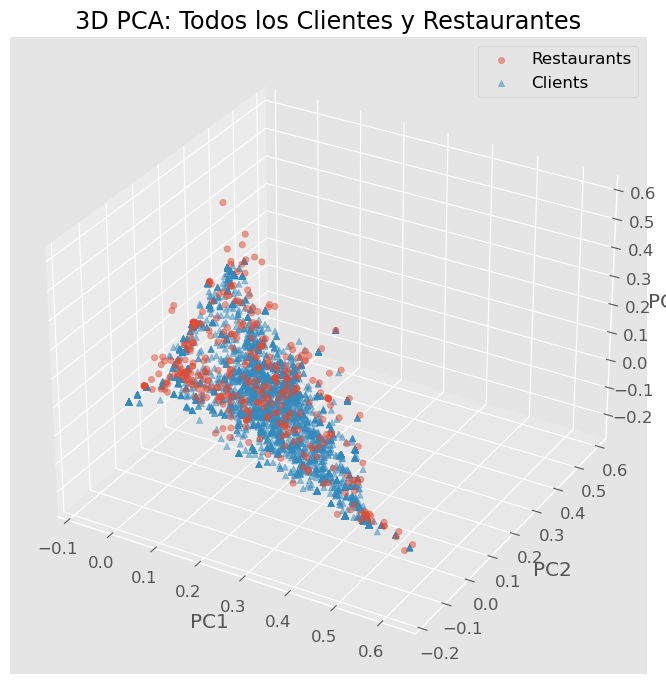

In [196]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Asegúrate de tener estos DataFrames definidos:
# df_final                         # Clientes con columnas de categoría
# df_categorias_restaurantes_clubers # Restaurantes con mismas columnas de categoría

# 1. Detecta las columnas de característica (todas menos Id/metadata)
feature_cols = [
    c for c in df_categorias_restaurantes_clubers.columns
    if c not in ('EstablishmentId', 'category')
]

# 2. Extrae las matrices de características
X_clients = df_final[feature_cols].values
X_rests   = df_categorias_restaurantes_clubers[feature_cols].values

# 3. Pila y aplica PCA a 3 componentes
X_all = np.vstack([X_clients, X_rests])
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_all)

# 4. Separa los transformados de clientes y restaurantes
Xc = X_pca[:len(X_clients)]
Xr = X_pca[len(X_clients):]

# 5. Grafica en 3D
fig = plt.figure(figsize=(10,7))
ax  = fig.add_subplot(projection='3d')

ax.scatter(Xr[:,0], Xr[:,1], Xr[:,2], marker='o', alpha=0.5, label='Restaurants')
ax.scatter(Xc[:,0], Xc[:,1], Xc[:,2], marker='^', alpha=0.5, label='Clients')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA: Todos los Clientes y Restaurantes')
ax.legend(loc='best')

plt.tight_layout()
plt.show()


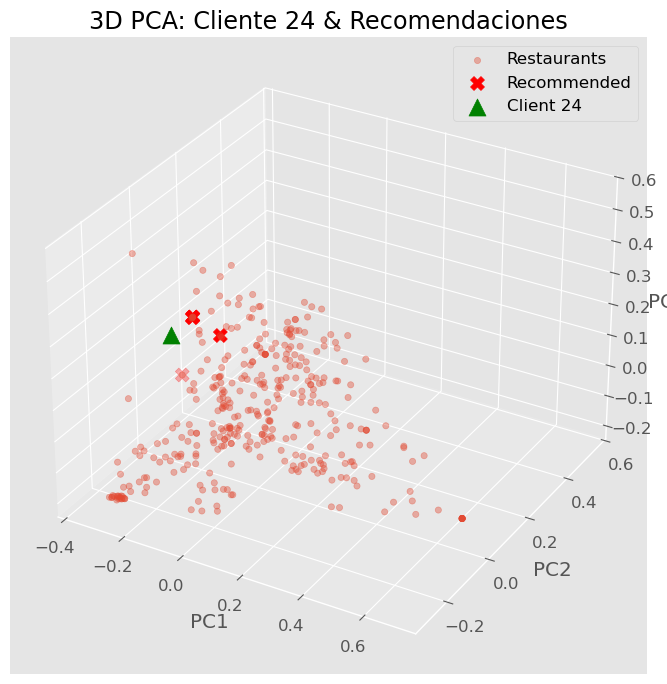

        RestaurantName  distance  similarity   Latitude   Longitude
0             Habacu's  0.125451    0.874549  25.726644 -100.297942
1        MXX Snack Bar  0.142679    0.857321  25.651729 -100.265291
2      Martins Lincoln  0.149804    0.850196  25.714617 -100.349498
3  Martins Universidad  0.149804    0.850196  25.745974 -100.300899
4        Martins Valle  0.151019    0.848981  25.664191 -100.382056


In [198]:
# Ejemplo:
top5 = recommend_restaurants_for_client_KNN(24, n=5)
print(top5)


# SVD

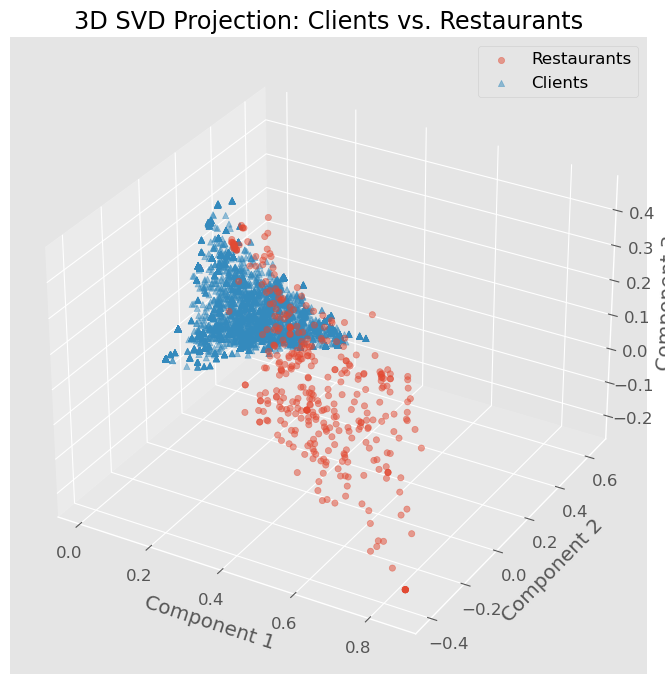

In [199]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Asumiendo que ya tienes df_final y df_categorias_restaurantes_clubers en el entorno

# 1. Normalizar nombres de columnas rápidamente
df_final.columns = [c.strip().replace(' ', '_') for c in df_final.columns]
df_categorias_restaurantes_clubers.columns = [c.strip().replace(' ', '_') for c in df_categorias_restaurantes_clubers.columns]

# 2. Detectar columnas de características
feature_cols = [c for c in df_categorias_restaurantes_clubers.columns if c not in ('EstablishmentId','category')]

# 3. Preparar matrices de características
X_rests = df_categorias_restaurantes_clubers[feature_cols].values
X_clients = df_final[feature_cols].values

# 4. Entrenar SVD (al menos 3 componentes)
svd = TruncatedSVD(n_components=3, random_state=42)
X_rests_svd = svd.fit_transform(X_rests)
X_clients_svd = svd.transform(X_clients)

# 5. Graficar en 3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')

# Restaurantes
ax.scatter(X_rests_svd[:,0], X_rests_svd[:,1], X_rests_svd[:,2], marker='o', alpha=0.5, label='Restaurants')

# Clientes
ax.scatter(X_clients_svd[:,0], X_clients_svd[:,1], X_clients_svd[:,2], marker='^', alpha=0.5, label='Clients')

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('3D SVD Projection: Clients vs. Restaurants')
ax.legend(loc='best')

plt.tight_layout()
plt.show()


In [200]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

# Asumiendo que ya tienes X_rests_svd, X_clients_svd, df_final, df_categorias_restaurantes_clubers y df_rest_info definidos

def recommend_restaurants_for_client_SVD(client_id, n=5, plot_3d=True):
    # 4.1 Localiza índice del cliente
    idxs = df_final.index[df_final['NumeroSocioConsumidor'] == client_id].tolist()
    if not idxs:
        raise ValueError(f"Cliente {client_id} no encontrado en df_final.")
    client_vec_svd = X_clients_svd[idxs[0]].reshape(1, -1)
    
    # 4.2 Calcula distancias coseno en espacio SVD
    dists = cosine_distances(client_vec_svd, X_rests_svd)[0]
    
    # 4.3 Índices de los n más cercanos
    nearest = dists.argsort()[:n]
    
    # 4.4 Construye DataFrame de recomendaciones
    recs = pd.DataFrame({
        'EstablishmentId': df_categorias_restaurantes_clubers.iloc[nearest]['EstablishmentId'].values,
        'distance': dists[nearest]
    })
    recs['similarity'] = 1 - recs['distance']
    
    # 4.5 Une con info de nombre y coordenadas
    recs = recs.merge(df_rest_info, on='EstablishmentId', how='left')
    result = recs[['RestaurantName','distance','similarity','Latitude','Longitude']]
    
    # Plot 3D en espacio SVD
    if plot_3d:
        from mpl_toolkits.mplot3d import Axes3D  # habilita proyección 3D
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(projection='3d')
        
        # Todos los restaurantes
        ax.scatter(X_rests_svd[:,0], X_rests_svd[:,1], X_rests_svd[:,2],
                   marker='o', alpha=0.4, label='Restaurants')
        # Recomendados
        ax.scatter(X_rests_svd[nearest,0], X_rests_svd[nearest,1], X_rests_svd[nearest,2],
                   marker='X', s=100, c='red', label='Recommended')
        # Cliente
        ax.scatter(client_vec_svd[0,0], client_vec_svd[0,1], client_vec_svd[0,2],
                   marker='^', s=150, c='green', label=f'Client {client_id}')
        
        ax.set_xlabel('SVD Comp1')
        ax.set_ylabel('SVD Comp2')
        ax.set_zlabel('SVD Comp3')
        ax.set_title(f'3D SVD: Cliente {client_id} & Recomendados')
        ax.legend(loc='best')
        plt.tight_layout()
        plt.show()
    
    return result




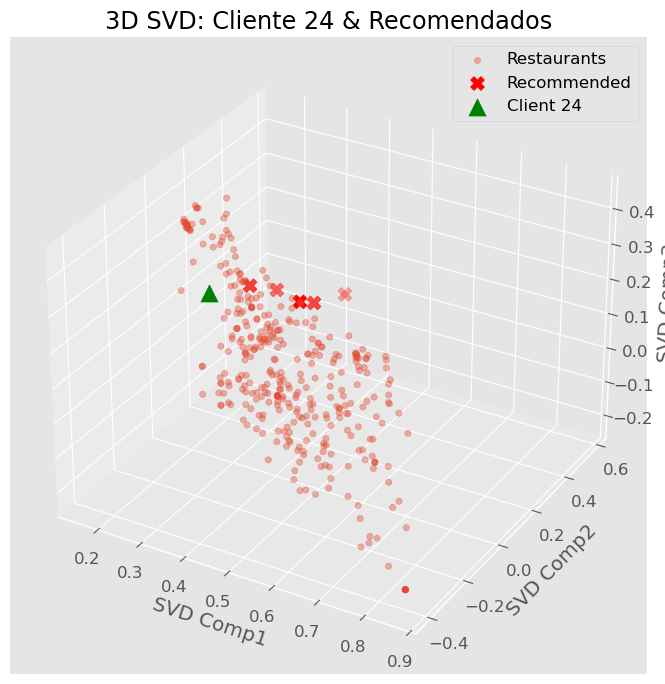

         RestaurantName  distance  similarity   Latitude   Longitude
0         MXX Snack Bar  0.006889    0.993111  25.651729 -100.265291
1     Buffalo Hot Wings  0.009497    0.990503  25.648387 -100.325137
2   Napoli Pizza Contry  0.029846    0.970154  25.641534 -100.280047
3             Mr. Elote  0.032782    0.967218  25.639875 -100.284615
4  Napoli Pizza Colinas  0.048330    0.951670  25.693234 -100.377977


In [201]:
# Ejemplo de uso
top5_svd = recommend_restaurants_for_client_SVD(24, n=5)
import pandas as pd; print(top5_svd)

# Agglomerative Clustering

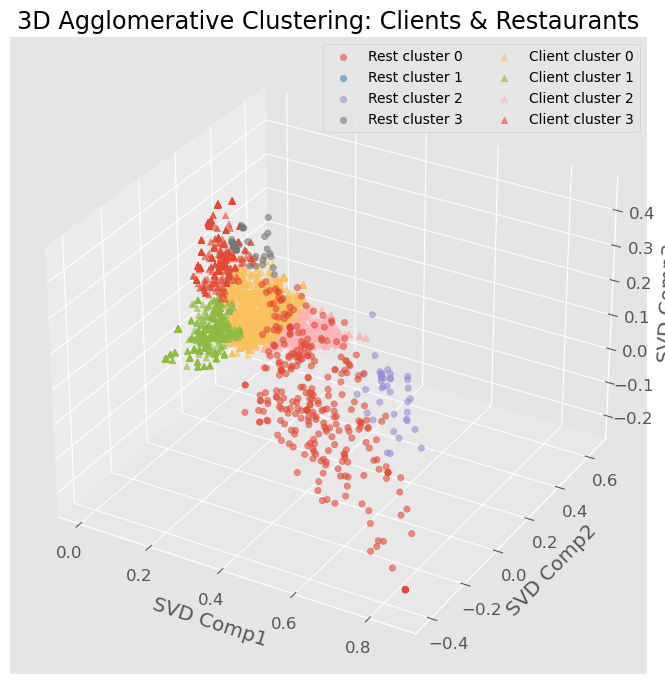

In [202]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd

# —————— 0. (Re)calcula SVD a 3 dimensiones  ——————
feature_cols = [c for c in df_categorias_restaurantes_clubers.columns 
                if c not in ('EstablishmentId','category')]
X_rests = df_categorias_restaurantes_clubers[feature_cols].values
X_clients = df_final[feature_cols].values

svd = TruncatedSVD(n_components=3, random_state=42)
X_rests_svd   = svd.fit_transform(X_rests)
X_clients_svd = svd.transform(X_clients)

# —————— 1. Combina restaurantes + clientes ——————
X_all = np.vstack([X_rests_svd, X_clients_svd])
labels_source = np.array(['rest']*len(X_rests_svd) + ['client']*len(X_clients_svd))

# —————— 2. Aplica Agglomerative Clustering ——————
# Elige un número de clústeres k
k = 4
agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
clusters = agg.fit_predict(X_all)

# —————— 3. Separa etiquetas ——————
rest_clusters  = clusters[labels_source=='rest']
client_clusters = clusters[labels_source=='client']

# —————— 4. Visualiza en 3D ——————
fig = plt.figure(figsize=(10,7))
ax  = fig.add_subplot(projection='3d')

# Plot restaurantes
for cl in range(k):
    mask = (labels_source=='rest') & (clusters==cl)
    ax.scatter(
        X_all[mask,0], X_all[mask,1], X_all[mask,2],
        marker='o', alpha=0.6,
        label=f'Rest cluster {cl}'
    )

# Plot clientes
for cl in range(k):
    mask = (labels_source=='client') & (clusters==cl)
    ax.scatter(
        X_all[mask,0], X_all[mask,1], X_all[mask,2],
        marker='^', alpha=0.6,
        label=f'Client cluster {cl}'
    )

ax.set_xlabel('SVD Comp1')
ax.set_ylabel('SVD Comp2')
ax.set_zlabel('SVD Comp3')
ax.set_title('3D Agglomerative Clustering: Clients & Restaurants')
ax.legend(loc='best', ncol=2, fontsize='small')
plt.tight_layout()
plt.show()


# Light FM

In [205]:
!pip install lightfm

  Using cached lightfm-1.17.tar.gz (316 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [386 lines of output]
      Compiling without OpenMP support.
      /opt/anaconda3/lib/python3.12/site-packages/setuptools/dist.py:452: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              **********************************

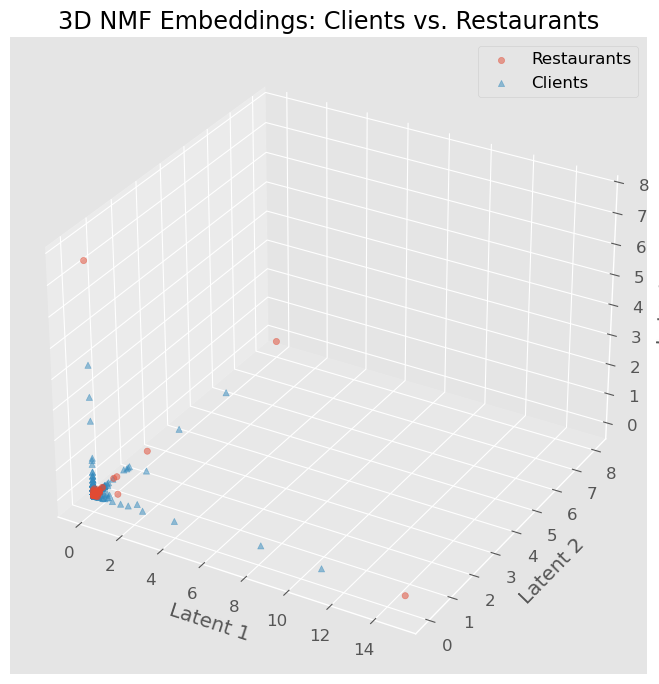

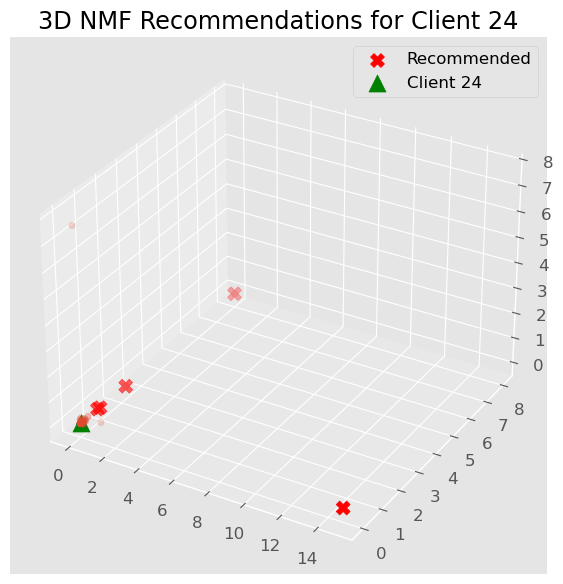

                         RestaurantName     score   Latitude   Longitude
0                               Calle 7  0.402887  25.651086 -100.334879
1              John Ham's Fashion Drive  0.109136  25.651110 -100.334829
2                                  Test  0.050276  35.632896  139.880394
3  Texas Smokeyard Barbecue San Agustin  0.044679  25.652913 -100.338009
4          Buffalo Pizza Fashion Drive   0.041707  25.651276 -100.335163


In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # activa proyección 3D
from sklearn.decomposition import NMF

# —————— 0. Carga y preprocesa tus datos ——————
# df_ord: ['NumeroSocioConsumidor','NumeroProveedor']
# df_rest_info: EstablishmentId, RestaurantName, Latitude, Longitude
# df_final: NumeroSocioConsumidor + tus vectores de categoría (no los necesitas aquí)

# Ejemplo de carga:
# df_ord       = pd.read_csv('ordenes-consumos.csv', encoding='latin1')
# df_rest_info = pd.read_csv('socios-proveedores.csv', encoding='latin1')
# df_final     = pd.read_csv('gustos_clientes_normalizados.csv', encoding='latin1')

# Asegura que sean ints
df_ord['NumeroSocioConsumidor'] = df_ord['NumeroSocioConsumidor'].astype(int)
df_ord['NumeroProveedor']      = df_ord['NumeroProveedor'].astype(int)

# —————— 1. Construye la matriz de interacciones R ——————
R = df_ord.pivot_table(
    index='NumeroSocioConsumidor',
    columns='NumeroProveedor',
    values='OrderID',       # o cualquier columna que cuente
    aggfunc='count',
    fill_value=0
)

# Guarda mapeos para recomendaciones
user_ids = R.index.to_list()
item_ids = R.columns.to_list()

# —————— 2. Entrena NMF (3 factores latentes) ——————
nmf = NMF(n_components=3, init='nndsvda', random_state=42, max_iter=200)
U = nmf.fit_transform(R.values)   # shape (n_users, 3)
V = nmf.components_.T             # shape (n_items, 3)

# —————— 3. Gráfica 3D global de embeddings ——————
fig = plt.figure(figsize=(10,7))
ax  = fig.add_subplot(projection='3d')

ax.scatter(V[:,0], V[:,1], V[:,2], marker='o', alpha=0.5, label='Restaurants')
ax.scatter(U[:,0], U[:,1], U[:,2], marker='^', alpha=0.5, label='Clients')

ax.set_xlabel('Latent 1')
ax.set_ylabel('Latent 2')
ax.set_zlabel('Latent 3')
ax.set_title('3D NMF Embeddings: Clients vs. Restaurants')
ax.legend(loc='best')
plt.tight_layout()
plt.show()



In [ ]:
# —————— 4. Función de recomendación + plot 3D local ——————
def recommend_with_nmf_3d(client_id, n=5):
    # 4.1 Índice del cliente
    if client_id not in user_ids:
        raise ValueError(f"Cliente {client_id} no está en datos de interacción.")
    ui = user_ids.index(client_id)
    client_vec = U[ui].reshape(1, -1)
    
    # 4.2 Scores = cliente·restaurante (producto escalar)
    scores = (V @ client_vec.T).flatten()
    top_idx = np.argsort(-scores)[:n]
    
    # 4.3 Plot 3D: todos, recomendaciones y cliente
    fig = plt.figure(figsize=(8,6))
    ax  = fig.add_subplot(projection='3d')
    ax.scatter(V[:,0], V[:,1], V[:,2], marker='o', alpha=0.2)
    ax.scatter(V[top_idx,0], V[top_idx,1], V[top_idx,2],
               marker='X', s=100, c='red', label='Recommended')
    ax.scatter(client_vec[0,0], client_vec[0,1], client_vec[0,2],
               marker='^', s=150, c='green', label=f'Client {client_id}')
    ax.set_title(f'3D NMF Recommendations for Client {client_id}')
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # 4.4 Resultados en tabla
    rec_ids = [item_ids[i] for i in top_idx]
    recs = pd.DataFrame({
        'EstablishmentId': rec_ids,
        'score': scores[top_idx]
    })
    recs = recs.merge(
        df_rest_info.rename(columns={'Id':'EstablishmentId'}),
        on='EstablishmentId',
        how='left'
    )
    return recs[['RestaurantName','score','Latitude','Longitude']]


In [ ]:

# —————— 5. Prueba para el cliente 24 ——————
top5_nmf = recommend_with_nmf_3d(24, n=5)
print(top5_nmf)
